# Building a Slater determinant basis and computing energies and NACs in this basis

In [ ]:
!tar res.tar.xz

In [13]:
from liblibra_core import *
import os
import sys
import time
from libra_py.workflows.nbra import step3
from libra_py import data_conv, data_outs, data_stat, units

import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


In [14]:
h0 = data_conv.nparray2CMATRIX( np.array([ [1.0, 0.0], [0.0, 2.0]]) )
h1 = data_conv.nparray2CMATRIX( np.array([ [1.0, 0.0], [0.0, 1.5]]) )
h2 = data_conv.nparray2CMATRIX( np.array([ [1.0, 0.0], [0.0, 0.0]]) )
h3 = data_conv.nparray2CMATRIX( np.array([ [1.0, 0.0], [0.0,-1.0]]) )
hvib_test = [ [ h0, h1, h2, h3 ] ]

for index, h in enumerate(hvib_test[0]):    
    print(F"======={index} ==========")
    data_outs.print_matrix(h)

=======0 ==========
(1+0j)  0j  
0j  (2+0j)  
=======1 ==========
(1+0j)  0j  
0j  (1.5+0j)  
=======2 ==========
(1+0j)  0j  
0j  0j  
=======3 ==========
(1+0j)  0j  
0j  (-1+0j)  


In [15]:
help(step3.sort_SD_energies)

Help on function sort_SD_energies in module libra_py.workflows.nbra.step3:

sort_SD_energies(Hvib)
    This function goes into the Hvib (SD basis) files and sorts the energies
    For each Hvib file, we are going to obtain a list of lists of orbital index and energy pair
    These orbital index and energy pairs for each step will be sorted based on energies  
    
    Args:
        Hvib ( list of lists of CMATRIX objects ): vibronic Hamiltonian in the Slater determinant basis



In [16]:
sorting = step3.sort_SD_energies( hvib_test)

for h in sorting[0]:
    print(h)

[[0, 1.0], [1, 2.0]]
[[0, 1.0], [1, 1.5]]
[[1, 0.0], [0, 1.0]]
[[1, -1.0], [0, 1.0]]


In [17]:
help(step3.output_sorted_Hvibs)

Help on function output_sorted_Hvibs in module libra_py.workflows.nbra.step3:

output_sorted_Hvibs(Hvib, orbital_index_energy_pairs, _params={})
    This function outputs the vibronic Hamiltonians in the SD basis according to their sorted order
    
    Args:
        Hvib ( list of lists of CMATRIX objects ): vibronic Hamiltonian in the Slater determinant basis
        orbital_index_energy_pairs ( list of lists of lists of lists ): orbital index and energy pair lists for each step and nuclear trajectory
                               Ex. orbital_index_energy_pairs[i][j][k][0] = kth slater determinant index at the jth step on the ith nuclear trajectory   
                               Ex. orbital_index_energy_pairs[i][j][k][1] = kth slater determinant energy at the jth step on the ith nuclear trajectory



In [18]:
hvib_sorted = step3.output_sorted_Hvibs(hvib_test, sorting)

for index, h in enumerate(hvib_sorted[0]):    
    print(F"======={index} ==========")
    data_outs.print_matrix(h)

=======0 ==========
(1+0j)  0j  
0j  (2+0j)  
=======1 ==========
(1+0j)  0j  
0j  (1.5+0j)  
=======2 ==========
0j  0j  
0j  (1+0j)  
=======3 ==========
(-1+0j)  0j  
0j  (1+0j)  


In [19]:
help(step3.get_step2_data)

Help on function get_step2_data in module libra_py.workflows.nbra.step3:

get_step2_data(_params)
    A light function to obtain the step2 data: S, St, hvib
    
    Args:
        params ( dictionary ): Control paramerter of this type of simulation. Can include the follwing keys:
    
        * **params["read_S_data"]** ( int ): whether to read S data (1) or not (0) [ default: 1 ]
    
        * **params["S_data_re_prefix"]** ( string ): prefix of files containing real part of orbital overlaps [ default: "S_dia_ks_" ]
    
        * **params["S_data_re_suffix"]** ( string ): suffix of files containing real part of orbital overlaps [ default: "_re" ]
    
        * **params["S_data_im_prefix"]** ( string ): prefix of files containing imaginary part of orbital overlaps [ default: "S_dia_ks_" ]
    
        * **params["S_data_im_suffix"]** ( string ): suffix of files containing imaginary part of orbital overlaps [ default: "_im" ]
    
        * **params["read_St_data"]** ( int ): whether

In [20]:
# Remove the previous results and temporary working directory from the previous runs. Create a new directory
os.system("rm -r traj0"); os.system("mkdir traj0")

# Create a path to the results directory from step2
res_dir = "res/"

# Set variables based on your data in step2. Indexing is from 1
num_alpha_ks_orbs = 86 # Number of alpha spin-orbtials in the alpha spin-block from the step2 data. By extension, this is also the number of beta spin-orbitals
data_dim          = 2*num_alpha_ks_orbs # Total number of rows or columns in the step2 data. Keep this value 2*num_alpha_ks_orbs
act_sp            = range(data_dim)     # Consider every spin-orbital to be in our active space
start_time  = 0    # Start reading step2 data at this index   
finish_time = 99   # Stop  reading step2 data at this index   

# Make a parameters dictionary with the relevant information about the step2 data, and then fetch this data
params = { "data_set_paths" : [res_dir],
           "data_dim":data_dim, "active_space":act_sp,
           "isnap":start_time,  "fsnap":finish_time,
         }

# These files contain N x N matrices, which are composed of N/2 x N/2 blocks of alpha and beta orbitals

params.update( { "read_S_data" : 1, 
                 "S_data_re_prefix": "S_dia_ks_",  "S_data_re_suffix": "_re",
                 "S_data_im_prefix": "S_dia_ks_",  "S_data_im_suffix": "_im",
                 "read_St_data" : 1,
                 "St_data_re_prefix": "St_dia_ks_",  "St_data_re_suffix": "_re",
                 "St_data_im_prefix": "St_dia_ks_",  "St_data_im_suffix": "_im",
                 "read_hvib_data" : 1,
                 "hvib_data_re_prefix": "hvib_dia_",  "hvib_data_re_suffix": "_re",
                 "hvib_data_im_prefix": "hvib_dia_",  "hvib_data_im_suffix": "_im" }
             )
    
S, St, Hvib_ks = step3.get_step2_data(params)

In [21]:
data_outs.print_matrix(Hvib_ks[0][1])

(-0.19019952+0j)  -0.00011358709j  1.8397831e-05j  -8.2135845e-05j  6.4329027e-05j  4.7086699e-05j  -0.00055837728j  -3.4023382e-05j  -0.00014293861j  -9.4543528e-06j  -2.4810519e-06j  -3.5948247e-06j  -1.2806266e-05j  4.7558175e-06j  -8.8717936e-06j  -1.3686824e-05j  -2.1532417e-07j  -1.7088325e-05j  -0.00015008447j  0.0001078054j  -1.5134745e-05j  5.9839674e-06j  -8.3157153e-05j  -1.2137378e-05j  2.8986484e-05j  1.4687708e-06j  -1.8022345e-05j  2.9928248e-06j  2.2959284e-07j  3.9489126e-08j  1.5031764e-06j  -1.4650952e-05j  1.8642365e-05j  -3.963785e-06j  2.9022115e-06j  4.7220897e-05j  -5.4334985e-06j  2.2065487e-05j  1.1437962e-06j  -2.8488805e-06j  3.3171521e-05j  7.8554415e-06j  7.0338611e-07j  -8.4088826e-06j  -1.8732695e-06j  3.5050028e-06j  -1.159411e-05j  -9.4941652e-06j  -1.6955181e-05j  -6.5533862e-07j  -2.0192569e-05j  -2.0844309e-07j  -7.2004398e-07j  1.6364435e-05j  -3.0960455e-05j  2.0733324e-05j  -6.4791837e-06j  1.3585561e-05j  3.9720371e-08j  -1.0907545e-05j  2.78447

In [23]:
SD_basis_unsorted = [ [15, -101], [16, -101], [17, -101] ]
step3.print_SD_basis(SD_basis_unsorted)
print("Number of Slater Determinant Basis States is:", len(SD_basis_unsorted))
params.update( { "SD_basis":SD_basis_unsorted } )

 GS:  [15, -101]
 ES 1:  [16, -101]
 ES 2:  [17, -101]

Number of Slater Determinant Basis States is: 3


In [24]:
SD_basis_unsorted = [ [14, 15, -100, -101], [14, 16, -100, -101], [14, 17, -100, -101] ]
step3.print_SD_basis(SD_basis_unsorted)
print("Number of Slater Determinant Basis States is:", len(SD_basis_unsorted))
params.update( { "SD_basis":SD_basis_unsorted } )

 GS:  [14, 15, -100, -101]
 ES 1:  [14, 16, -100, -101]
 ES 2:  [14, 17, -100, -101]

Number of Slater Determinant Basis States is: 3


In [36]:
# Use Libra to automatically generate the orbitals from Example 1.    
excitation_type = 0 # Select 0 for only alpha-excitations
                    # Select 1 for only beta-excitations
                    # Select 2 for both alpha and beta-excitations
cbm_alpha_index   = 15  # Which of the spin-orbtials is the CBM for the alpha-spin channel? 
cbm_beta_index    = 101 # Which of the spin-orbtials is the CBM for the beta-spin  channel?
alpha_include     = 3  # how many orbitals to include from the cbm alpha index (how many from band edges)
beta_include      = 3  # how many orbitals to include from the cbm beta  index (how many from band edges)
print ("\nGenerating a SD basis for dynamics ...")
print (" You are using "+str(data_dim)+" KS orbitals with an alpha CBM index of "+str(cbm_alpha_index)+" and beta CBM index of "+str(cbm_beta_index)+". Indexing is from 1")
print (" Including", alpha_include, " alpha ks orbitals from the band edges")
print (" Including", beta_include,  " beta  ks orbitals from the band edges")
print (" Chosen Excitation type: ", excitation_type)
print ("  0: only alpha excitations")
print ("  1: only beta  excitations")
print ("  2: both alpha and beta excitations")
print ("Here is your SD basis generated by Libra:")
SD_basis_unsorted = step3.build_SD_basis(data_dim, cbm_alpha_index, alpha_include, cbm_beta_index, beta_include, excitation_type)
step3.print_SD_basis(SD_basis_unsorted)
print("Number of Slater Determinant Basis States is:", len(SD_basis_unsorted))
params.update( { "SD_basis":SD_basis_unsorted } )
#sys.exit(0)


Generating a SD basis for dynamics ...
 You are using 172 KS orbitals with an alpha CBM index of 15 and beta CBM index of 101. Indexing is from 1
 Including 3  alpha ks orbitals from the band edges
 Including 3  beta  ks orbitals from the band edges
 Chosen Excitation type:  0
  0: only alpha excitations
  1: only beta  excitations
  2: both alpha and beta excitations
Here is your SD basis generated by Libra:
 GS:  [12, 13, 14, 15, -98, -99, -100, -101]
 ES 1:  [16, 13, 14, 15, -98, -99, -100, -101]
 ES 2:  [17, 13, 14, 15, -98, -99, -100, -101]
 ES 3:  [18, 13, 14, 15, -98, -99, -100, -101]
 ES 4:  [19, 13, 14, 15, -98, -99, -100, -101]
 ES 5:  [12, 16, 14, 15, -98, -99, -100, -101]
 ES 6:  [12, 17, 14, 15, -98, -99, -100, -101]
 ES 7:  [12, 18, 14, 15, -98, -99, -100, -101]
 ES 8:  [12, 19, 14, 15, -98, -99, -100, -101]
 ES 9:  [12, 13, 16, 15, -98, -99, -100, -101]
 ES 10:  [12, 13, 17, 15, -98, -99, -100, -101]
 ES 11:  [12, 13, 18, 15, -98, -99, -100, -101]
 ES 12:  [12, 13, 19, 

In [37]:
help(step3.build_SD_basis)

Help on function build_SD_basis in module libra_py.workflows.nbra.step3:

build_SD_basis(data_dim, cbm_alpha_index, alpha_include, cbm_beta_index, beta_include, excitation_type)
    Builds a Slater Determinant basis based on the indexing notation scheme used in Libra
    
    Args:
        data_dim (int): how many rows or columns in the vibronic Hamiltonian matrix. This will be an even number becuase the 
                        number of alpha orbtials should equal the number of beta orbitals
        cbm_(alpha/beta)_index (int): index of VBM (or HOMO) in the matrix of the vibronic Hamiltonian 
                                      (row or column index). Note, this index is from 1 
        (alpha/beta)_include (int): how many orbitals to include from the cbm_(alpha/beta)_index
        excitation_type (int):  0: Make SDs with beta electrons excited
                                1: Make SDs with alpha electrons excited
                                2: Make two sets of SDs, one for b

In [38]:
# Define the coefficients for a CI-like basis - just have the diagonals all 1 for now
CI_basis = []
SD_energy_corr = [0.0]*len(params["SD_basis"])
for i in range(len(params["SD_basis"])):
    CI_basis.append( [] )
    for j in range(len(params["SD_basis"])):
        if i == j:
            CI_basis[i].append(1.0)
        else:
            CI_basis[i].append(0.0)
            
params.update( { "CI_basis": CI_basis, "SD_energy_corr": SD_energy_corr } )

In [39]:
# Update parameters
params.update( { "output_set_paths" : [os.getcwd()+"/traj0/"],
                 "dt" : 1.0*units.fs2au,
                 "do_orthogonalization"  : 0, #activate for QE
                 "do_state_reordering"   : 0,
                 "state_reordering_alpha": 0.0,
                 "do_phase_correction"   : 0,
                 "do_output" : 1,
                 "Hvib_re_prefix":"Hvib_",  "Hvib_re_suffix":"_re",
                 "Hvib_im_prefix":"Hvib_",  "Hvib_im_suffix":"_im",
              } )
print("\nTransforming the KS basis to a SD one, computing the energies of the Slater determinant bases as sums of their one electron orbtials")
Hvib = step3.run(S, St, Hvib_ks, params)
print("Complete")


Transforming the KS basis to a SD one, computing the energies of the Slater determinant bases as sums of their one electron orbtials
Complete


In [40]:
# Now, at each time step (Each Hivb file) the order of the SDs may have changed (as we sort by energy)
# Therefore, we must get the sorted index at each step
# Sort the orbital indicies based on energy for each Hvib file
orbital_index_energy_pairs = step3.sort_SD_energies(Hvib)

print(len(orbital_index_energy_pairs))
print(len(orbital_index_energy_pairs[0]))
print(len(orbital_index_energy_pairs[0][0]))
print(orbital_index_energy_pairs[0][0])


# This commented line below was in the original version of this tutorial, but it is incorrect
# because the reordered Hamiltonians are not returned
#step3.output_sorted_Hvibs(Hvib, orbital_index_energy_pairs)


# Now, we need to actually re-write the Hvib files according to the sorting
# This is a correct version
Hvib = step3.output_sorted_Hvibs(Hvib, orbital_index_energy_pairs)


1
99
17
[[0, -1.01818384], [13, -1.01625065], [14, -1.009602705], [15, -1.008506381], [16, -1.00497854], [9, -0.99199164], [5, -0.99055224], [10, -0.9853436950000001], [11, -0.9842473709999999], [6, -0.9839042950000001], [1, -0.9837147500000001], [7, -0.982807971], [12, -0.98071953], [8, -0.97928013], [2, -0.977066805], [3, -0.9759704810000001], [4, -0.97244264]]


In [41]:
help(data_stat.cmat_stat2)

Help on function cmat_stat2 in module libra_py.data_stat:

cmat_stat2(X, opt)
    Computes the norm-N average of a list of CMATRIX(N,N) objects
    
    Args:
        X ( list of CMATRIX(N,N) objects ): the data to be analyzed
        opt ( int ): the option for averaging:
    
            * opt == 0 :  t_ij = <x_ij>  + i <y_ij>
            * opt == 1 :  t_ij = <|x_ij|>  + i <|y_ij|>
            * opt == 2 :  t_ij = sqrt(<x_ij^2>)  + i sqrt(<y_ij^2>)
            * opt == 3 :  t_ij = sqrt(<x_ij^2> + <y_ij^2>) = sqrt(|z_ij|^2) 
            
    Returns:
        CMATRIX(N,N): norm-N average of each matrix element of data



In [42]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nSDs   = Hvib[0][0].num_of_cols

# Make a list for the SD energies and populate it
SD_energy = []
md_time = list( range(nsteps) )
for sd_index in range( nSDs ):
    SD_energy.append( [] )
    for step in range( nsteps ):
        #print( Hvib[ 0 ][ step ].get( sd_index, sd_index ).real )
        SD_energy[ sd_index ].append( Hvib[ 0 ][ step ].get( sd_index, sd_index ).real - Hvib[ 0 ][ step ].get( 0, 0 ).real )
SD_energy  = np.array( SD_energy  )
md_time    = np.array( md_time )
#sys.exit(0)

# Compute the time-averaged SD NACs and make a list of them
sd_res = data_stat.cmat_stat2(Hvib[0], 2)
sd_tNACs = []
for i in range(nSDs):
    sd_tNACs.append( [] )
    for j in range(nSDs):
        sd_tNACs[i].append( sd_res.get(i,j).imag * 1000.0 / units.ev2Ha )
sd_tNACs = np.array(sd_tNACs)

# Make a list for the KS energies and populate it
KS_energy = []
for ks_index in range( num_alpha_ks_orbs ):
    KS_energy.append( [] )
    for step in range( nsteps ):
        #print( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
        KS_energy[ ks_index ].append( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
KS_energy  = np.array( KS_energy  )

# Compute the time-averaged KS NACs and make a list of them
ks_res = data_stat.cmat_stat2(Hvib_ks[0], 2)
ks_tNACs = []
ks_orbs_to_print = range(int(data_dim/2))
for i in range(num_alpha_ks_orbs):
    ks_tNACs.append( [] )
    for j in range(num_alpha_ks_orbs):
        ks_tNACs[i].append( ks_res.get(i,j).imag * 1000.0 / units.ev2Ha )
    

We now will plot the time-dependent kohn-sham energies and the time-averaged nonadiabatic ouplings between them

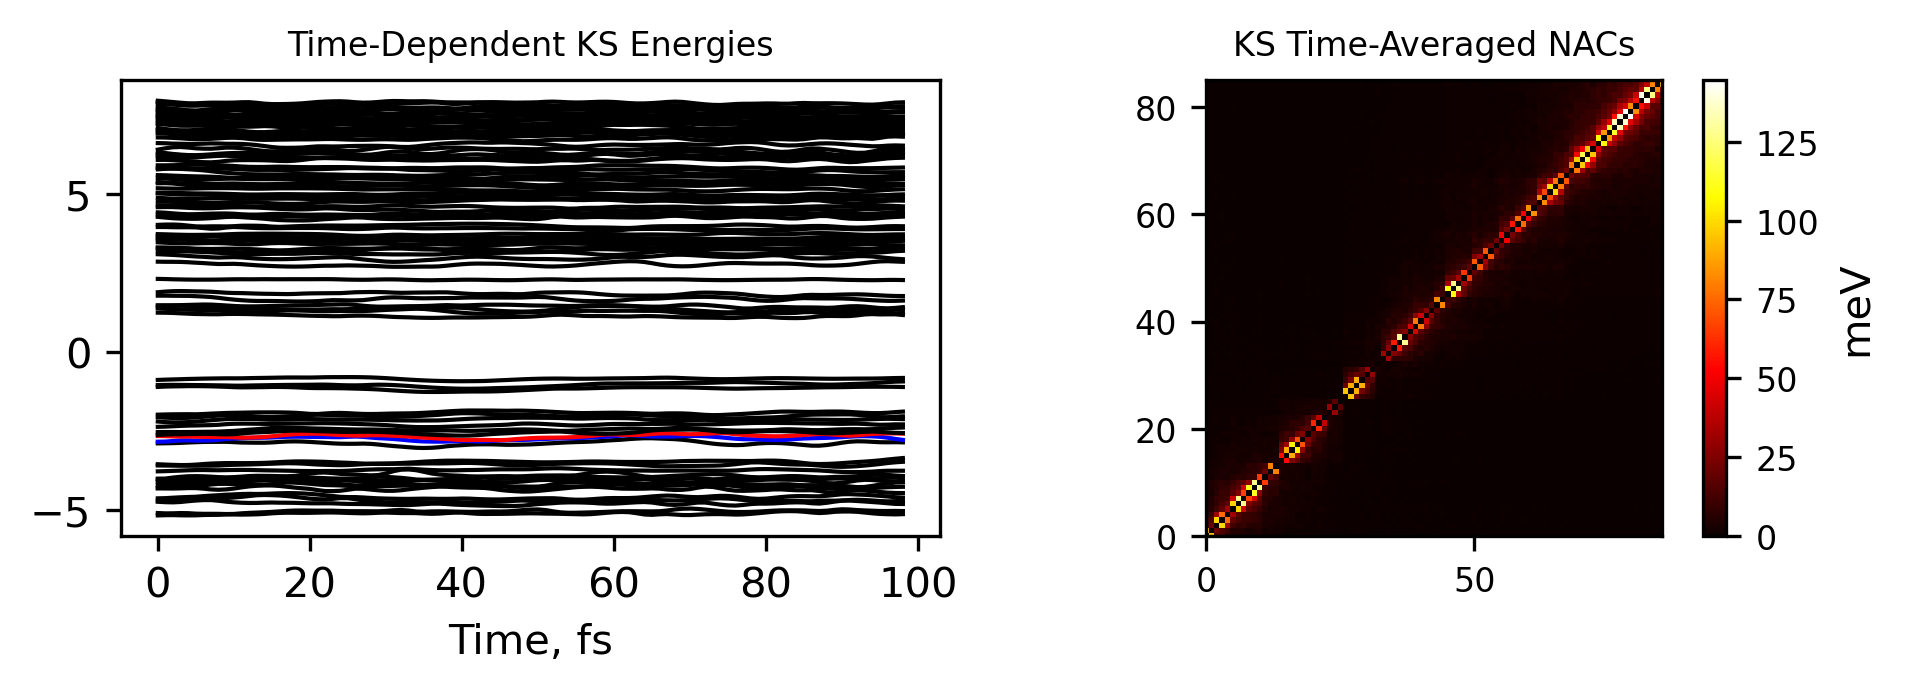

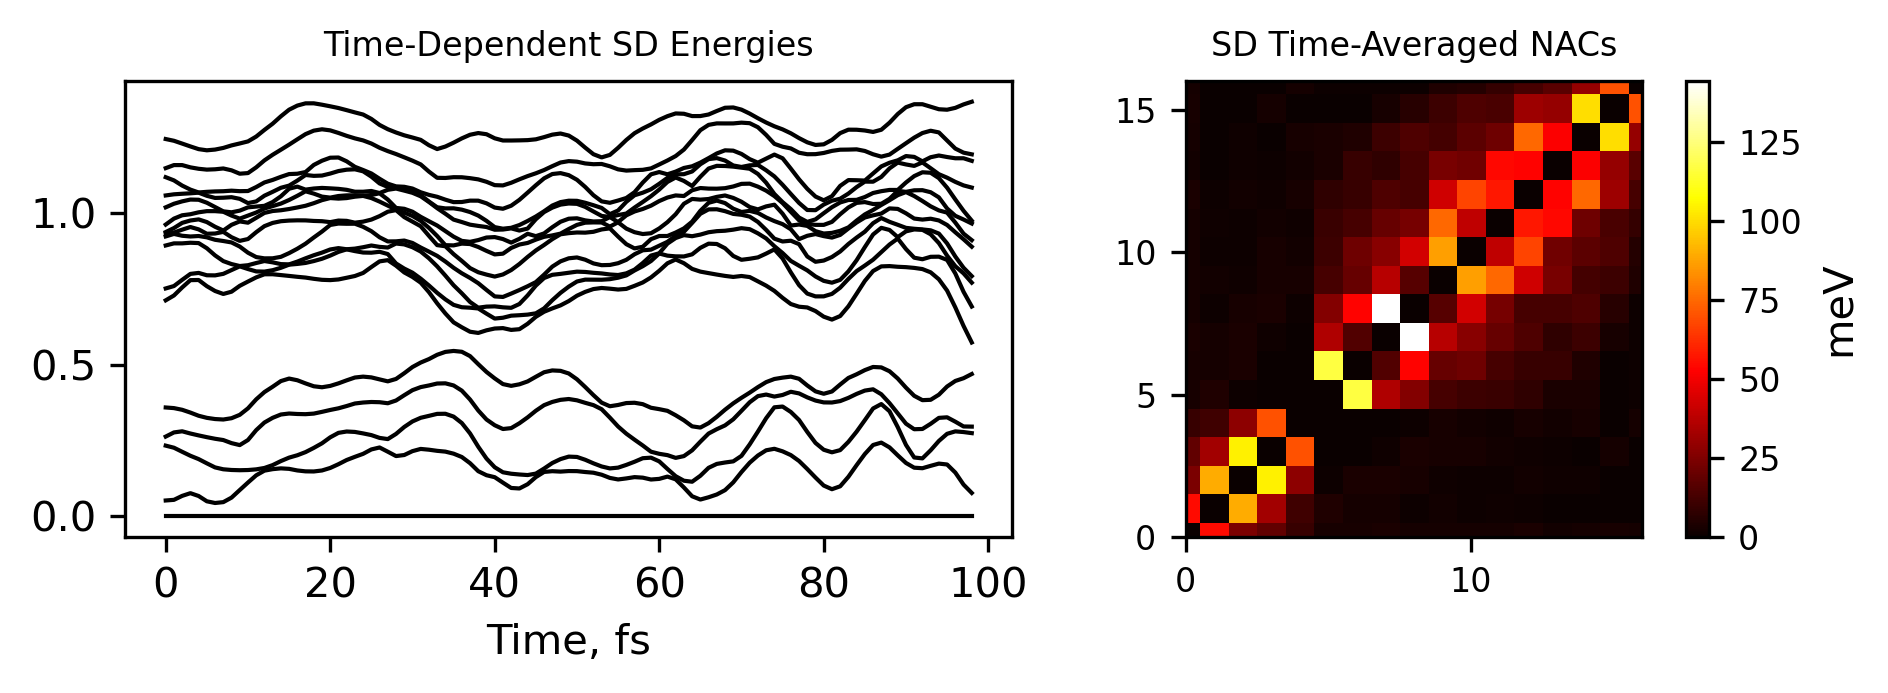

In [44]:
# Figures - Time-Dependent Data
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.title('Time-Dependent KS Energies', fontsize=8)
plt.xlabel('Time, fs')
for ks_index in range( num_alpha_ks_orbs ):
    if ks_index == 15:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="VBM", linewidth=1, color = "blue")
    elif ks_index == 16:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="CBM", linewidth=1, color = "red")
    else:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('KS Time-Averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,num_alpha_ks_orbs-1)
plt.ylim(0,num_alpha_ks_orbs-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ks_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)


plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.title('Time-Dependent SD Energies', fontsize=8)
plt.xlabel('Time, fs')
for sd_index in range( nSDs ):
    plt.plot(md_time, (SD_energy[sd_index]-SD_energy[0])/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('SD Time-Averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,nSDs-1)
plt.ylim(0,nSDs-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(sd_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()